# Using the `ncbi.datasets` python library to navigate NCBI assembly data

The `ncbi.datasets` python library can be used to query NCBI datasets and navigate through the results quickly within python. 

## Getting started

First, let's import the python modules we'll use.  Be sure you have first installed the requirements in 'requirements.txt' into your virtual environment.

In [1]:
import sys
import zipfile
import pandas as pd
from pprint import pprint
from datetime import datetime
from collections import defaultdict, Counter
from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('ggplot')

try:
    import ncbi.datasets
except ImportError:
    print('ncbi.datasets module not found. To install, run `pip install ncbi-datasets-pylib`.')

## Genome summaries

Genome summaries include all the metadata you'll need, and can be accessed in four ways:
1. accession: an NCBI Assembly accession
2. organism: an organism or a taxonomical group name 
3. taxid: using an NCBI Taxonomy identifier, at any level.
4. BioProject: using an NCBI BioProject accession

First, we'll need an api object specific to retrieving assembly descriptors.  To see all the possible API instances, [visit the documentation on GitHub](https://github.com/ncbi/datasets/tree/master/client_docs/python#documentation-for-api-endpoints)

In [1]:
## start an api_instance 
api_instance = ncbi.datasets.GenomeApi(ncbi.datasets.ApiClient())

### Genome summaries by accession

Let's start with the simplest case.  Say you already know the NCBI Assembly accession, for example, for the latest human reference genome assembly (GRCh38), `GCF_000001405.40`.  Using the `assembly_descriptors_by_accessions()` method, we'll get back a `V1AssemblyDatasetDescriptors` object ([documented here](https://github.com/ncbi/datasets/blob/master/client_docs/python/docs/V1AssemblyDatasetDescriptors.md)) (a mouthful we know).  The various fields in the response are attributes of the object.

Let's see this in practice.

In [1]:
assembly_accessions = ['GCF_000001405.40'] ## needs to be a full accession.version

genome_summary = api_instance.assembly_descriptors_by_accessions(assembly_accessions, page_size=1)

type(genome_summary)


ncbi.datasets.openapi.model.v1_assembly_metadata.V1AssemblyMetadata

`genome_summary` contains metadata about the genome assembly and the total count of results in JSON format.

In [1]:
print(f"Number of assemblies: {genome_summary.total_count}" )

Number of assemblies: 1


In [1]:
## print other information 
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    print(
        assembly.assembly_accession,
        assembly.assembly_level,
        len(assembly.chromosomes),
        assembly.submission_date,
        sep='\t')

GCF_000001405.40	Chromosome	26	2019-02-28


In [1]:
print(genome_summary)

{'assemblies': [{'assembly': {'annotation_metadata': {'busco': {'busco_lineage': 'primates_odb10',
                                                                'busco_ver': '4.0.2 ',
                                                                'complete': 0.9920174,
                                                                'duplicated': 0.0066763423,
                                                                'fragmented': 0.0017416546,
                                                                'missing': 0.006240929,
                                                                'single_copy': 0.9853411,
                                                                'total_count': '13780'},
                                                      'file': [{'estimated_size': '50932266',
                                                                'type': 'GENOME_GFF'},
                                                               {'estimated_size': '1315687838',

### Genome summaries by organism or tax group name 

Now let's say you only know the name of the organism for which you want to retrieve assembly information.

In [1]:
## a few examples to try 
# tax_name = 'mammals'
# tax_name = 'birds'
# tax_name = 'butterflies'
tax_name = 'primates'

genome_summary = api_instance.assembly_descriptors_by_taxon(
    taxon=tax_name,
    page_size=1000)
print(f"Number of assemblies in the group '{tax_name}': {genome_summary.total_count}")

Number of assemblies in the group 'primates': 1040


#### Assemblies organized by GenBank/RefSeq
Now we can analyze the results and organize by GenBank and RefSeq, and make a nice tabular output and pie-chart of the results.

In [1]:
assm_counter = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if assembly.assembly_accession[:3] == 'GCA':
        assm_counter['GenBank'] += 1
    elif assembly.assembly_accession[:3] == 'GCF':
        assm_counter['RefSeq'] += 1
    
print(assm_counter)

Counter({'GenBank': 963, 'RefSeq': 37})


,count
GenBank,963
RefSeq,37


<AxesSubplot:title={'center':'Assemblies by type'}, ylabel='count'>

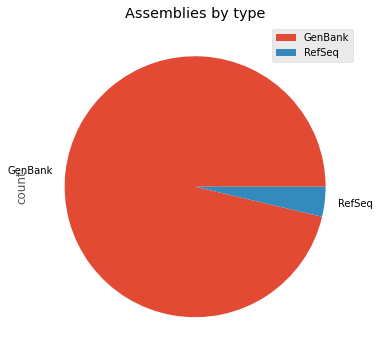

In [1]:
df = pd.DataFrame.from_dict(assm_counter, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by type')

#### Assemblies organized by assembly level
Alternatively, we can organize by the assembly level (scaffold, contig or choromosome).

In [1]:
assm_level = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    assm_level[assembly.assembly_level] += 1
    
print(assm_level)

Counter({'Scaffold': 828, 'Contig': 103, 'Chromosome': 68, 'Complete Genome': 1})


,count
Scaffold,828
Chromosome,68
Contig,103
Complete Genome,1


<AxesSubplot:title={'center':'Assemblies by level'}, ylabel='count'>

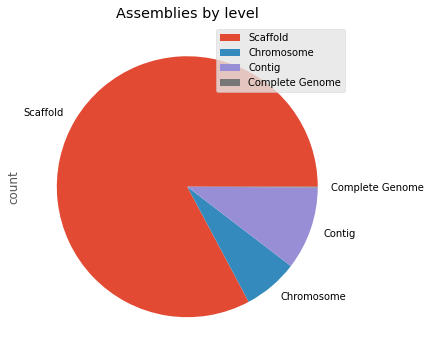

In [1]:
df = pd.DataFrame.from_dict(assm_level, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by level',)

#### Assemblies grouped and counted by annotation release number

All RefSeq assemblies are annotated and each annotation release is numbered, starting from 100. A quick way to check if the latest annotation is the first time an assembly for that organism was annotated is to check the annotation release number. Anything above 100 can be interpreted to have been through multiple annotations. 

For example, in the analysis shown below, the human assembly has an annotation release number 109 indicating that a human assembly was annotated multiple times. On the other hand, the silvery gibbon assembly has an annotation release number of 100 indicating that this is the first time an assembly from this organism was annotated. 

In [1]:
## out of the 28 RefSeq assemblies, how many have been annotated more than once? 
annot_counter = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if assembly.assembly_accession.startswith('GCF') and assembly.annotation_metadata and assembly.annotation_metadata.release_number:
        rel = int(assembly.annotation_metadata.release_number.split('.')[0])
        annot_counter[rel] += 1
pprint(annot_counter)

Counter({101: 7, 100: 4, 105: 3, 102: 3, 103: 3, 104: 2, 109: 1})


<AxesSubplot:>

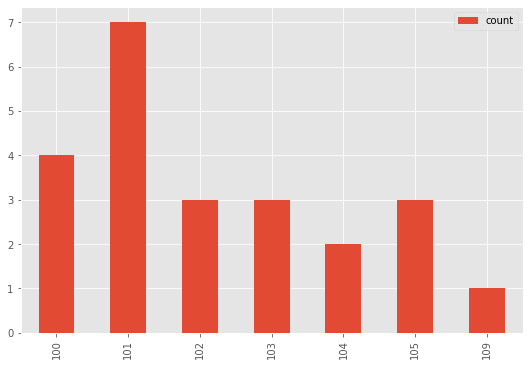

In [1]:
df = pd.DataFrame.from_dict(annot_counter, orient='index', columns=['count']).sort_index()
df.plot(kind='bar', y='count', figsize=(9,6))

#### Assemblies organized by annotation release number

In [1]:
annot_list = defaultdict(list)
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if assembly.assembly_accession.startswith('GCF') and assembly.annotation_metadata:
        rel = assembly.annotation_metadata.release_number
        annot_list[rel].append(assembly.assembly_accession + ' ' + assembly.org.title)
pprint(annot_list)

defaultdict(<class 'list'>,
            {None: ['GCF_000772875.2 Rhesus monkey',
                    'GCF_000001515.7 chimpanzee'],
             '100': ['GCF_000955945.1 sooty mangabey',
                     'GCF_000951035.1 Colobus angolensis palliatus',
                     'GCF_009828535.1 silvery gibbon',
                     'GCF_000951045.1 drill'],
             '101': ["GCF_000952055.2 Ma's night monkey",
                     'GCF_000164805.1 Philippine tarsier',
                     'GCF_001604975.1 Panamanian white-faced capuchin',
                     'GCF_009828535.2 silvery gibbon',
                     'GCF_000364345.1 crab-eating macaque',
                     'GCF_000956065.1 pig-tailed macaque',
                     'GCF_000165445.2 gray mouse lemur'],
             '102': ['GCF_015252025.1 green monkey',
                     'GCF_008122165.1 western lowland gorilla',
                     'GCF_000181295.1 small-eared galago'],
             '103': ['GCF_003339765.1 Rhesus

### Genomes summaries by taxid
Finally, you may want to query for genome assemblies by NCBI Taxonomy ID.  

In [1]:
# taxid = '8782' ## birds
# taxid = '7898' ## ray-finned fish
taxid = '37572' ## butterflies

genome_summary = api_instance.assembly_descriptors_by_taxon(
    taxon=taxid,
    page_size=100,
    filters_assembly_source='refseq')

In [1]:
print(f"Number of assemblies: {genome_summary.total_count}")

Number of assemblies: 11


In [1]:
## count number of GenBank and RefSeq assemblies
## all are RefSeq assemblies because 'filters_refseq_only=True' above
assm_counter = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    assm_counter[assembly.assembly_accession[:3]] += 1
    
print(assm_counter)

Counter({'GCF': 11})


#### Group assemblies by annotation date

In [1]:
annot_rel_dates = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if not assembly.annotation_metadata:
        continue
    rel_year = datetime.strptime(assembly.annotation_metadata.release_date, '%Y-%M-%d').year
    annot_rel_dates[rel_year] += 1
pprint(sorted(annot_rel_dates.items()))

[(2015, 3), (2017, 1), (2018, 2), (2020, 3), (2021, 1)]


<AxesSubplot:>

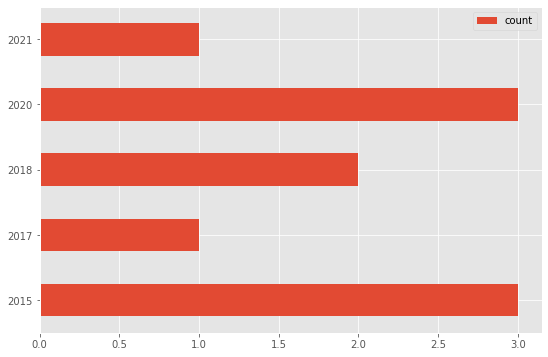

In [1]:
df = pd.DataFrame.from_dict(annot_rel_dates, orient='index', columns=['count']).sort_index()
df.plot(kind='barh', y='count', figsize=(9,6))

In [1]:
genome_table = {}
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if not assembly.annotation_metadata:
        continue
    n_chr = len(assembly.chromosomes) if assembly.assembly_level == 'Chromosome' else None
    genome_table[assembly.assembly_accession] = {
        'assm_name': assembly.display_name,
        'annot_rel_date': assembly.annotation_metadata.release_date,
        'annot_rel_num': assembly.annotation_metadata.release_number,
        'assm_level': assembly.assembly_level,
        'num_chromosomes': n_chr,
        'contig_n50': assembly.contig_n50,
        'seq_length': assembly.seq_length,
        'submission_date': assembly.submission_date }
df = pd.DataFrame.from_dict(genome_table, orient='columns')
display(df)

,GCF_900239965.1,GCF_009731565.1,GCF_902806685.1,GCF_001298355.1,GCF_000836215.1,GCF_000836235.1,GCF_905163445.1,GCF_001856805.1,GCF_002938995.1,GCF_012273895.1
assm_name,Bicyclus_anynana_v1.2,Dplex_v4,iAphHyp1.1,Pap_ma_1.0,Ppol_1.0,Pxut_1.0,ilParAegt1.1,P_rapae_3842_assembly_v2,ASM293899v1,Zerene_cesonia_1.1
annot_rel_date,2018-02-16,2020-02-24,2020-12-18,2015-10-28,2015-07-30,2015-07-31,2021-03-05,2017-08-08,2018-10-03,2020-12-23
annot_rel_num,100,100,100.20201218,100,100,100,100,100,100,100
assm_level,Scaffold,Chromosome,Chromosome,Scaffold,Scaffold,Scaffold,Chromosome,Scaffold,Scaffold,Chromosome
num_chromosomes,None,31,30,None,None,None,30,None,None,30
contig_n50,78697,108026,2012761,92238,47768,128246,19375358,54957,254123,43484
seq_length,475399557,248676414,408137179,278421261,227005758,243890167,516571003,245871251,357124929,266405969
submission_date,2018-01-02,2019-12-11,2020-02-22,2015-09-28,2015-02-02,2015-02-02,2021-01-28,2016-10-16,2018-02-23,2020-10-02


## Genome assembly downloads
So far, we have looked at interacting with genome summaries, which describe the essential metadata for genome assemblies. In addition to metadata, the Datasets API can be used to download a genome dataset consisting of genome, transcript, and protein sequences in FASTA format, as well as annotation data in gff3, gtf, and GenBank flat file formats.

To illustrate, let's start by downloading a genome dataset including mitochondrial genome sequence and all protein sequences for the latest human genome assembly, GRCh38.

In [1]:
assembly_accessions = ['GCF_000001405.40']
chromosomes = ['MT']
exclude_sequence = False
include_annotation_type = ['PROT_FASTA']

api_response = api_instance.download_assembly_package(
    assembly_accessions,
    chromosomes=chromosomes,
    exclude_sequence=exclude_sequence,
    include_annotation_type=include_annotation_type,
    # Because we are streaming back the results to disk, 
    # we should defer reading/decoding the response
    _preload_content=False
)

with open('human_assembly.zip', 'wb') as f:
    f.write(api_response.data)


Now we'll unzip the downloaded zip archive. All data is contained in ncbi_dataset/data. Data that is specific to the human reference genome, GRCh38, is contained within a subdirectory named with that assembly accession, GCF_000001405.40. 
The data directory contains five files:
 1. The assembly data report contains assembly information like sequence names,  NCBI accessions, UCSC-style chromosome names, and annotation statistics (gene counts). Note that this file is directly under the data directory and not in the subdirectory named with the assembly accession. When the genome dataset contains data for multiple assemblies, genome assembly metadata for all of these assemblies is contained in the `assembly_data_report.jsonl` file
 2. The sequence report (`sequence_report.jsonl`) contains a list of the sequences that comprise the GRCh38 assembly
 3. The nucleotide sequence in FASTA (nucleotide) format for the one "chromosome" we requested: `chrMT.fna`
 4. All protein sequences in FASTA (amino acid) format: `protein.faa`
 5. And finally, a dataset catalog file (`dataset_catalog.json`) that describes the contents of the archive, to aid in programmatic access.
Read more about the contents in the [download assembly command
 section of the documentation](https://www.ncbi.nlm.nih.gov/datasets/docs/command-line-assembly/).  

In [1]:
!unzip -v human_assembly.zip

Archive:  human_assembly.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
     661  Defl:N      384  42% 07-16-2021 15:01 bc3c97af  README.md
    1463  Defl:N      778  47% 07-16-2021 15:01 ef39e08a  ncbi_dataset/data/assembly_data_report.jsonl
   16834  Defl:N     5379  68% 07-16-2021 15:01 932c3ae8  ncbi_dataset/data/GCF_000001405.40/chrMT.fna
86751124  Defl:N 26333623  70% 07-16-2021 15:01 951c4924  ncbi_dataset/data/GCF_000001405.40/protein.faa
     211  Defl:N      166  21% 07-16-2021 15:01 28e03896  ncbi_dataset/data/GCF_000001405.40/sequence_report.jsonl
     499  Defl:N      214  57% 07-16-2021 15:01 d01d97f9  ncbi_dataset/data/dataset_catalog.json
--------          -------  ---                            -------
86770792         26340544  70%                            6 files


## Using genome summary data to request genome datasets

When you need to download a genome dataset for a particular taxonomic group, you'll need to first get the list of genome assembly accessions, then you can query by accession to download the data that you're interested in.

In this example, we'll download a genome dataset for a list of bird RefSeq genomes annotated in 2020.

1. Fetch a list of RefSeq assembly accessions for all rodent genomes using `assembly_descriptors_by_taxid` 
2. Filter assemblies that were annotated in 2020
3. Download data, but in this case, retrieve a dehydrated zip archive that can be rehydrated later to obtain the sequence data itself.

In [1]:
genome_summary = api_instance.assembly_descriptors_by_taxon(
    taxon='9989', ## Rodents taxid
    page_size=1000,
    filters_assembly_source='refseq')

print(f'Number of assemblies: {genome_summary.total_count}')

Number of assemblies: 45


In [1]:
annots_by_year = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if assembly.annotation_metadata:
        annot_year = int(assembly.annotation_metadata.release_date.split('-')[0])
        annots_by_year[annot_year] += 1
    else:
        print(f'No annotation for {assembly.assembly_accession}')
    
print(f'Assemblies grouped by year of annotation')
pprint(sorted(annots_by_year.items()))

No annotation for GCF_903992535.2
No annotation for GCF_000419365.1
No annotation for GCF_000230445.1
No annotation for GCF_000002165.2
No annotation for GCF_003704035.1
Assemblies grouped by year of annotation
[(2015, 3), (2016, 5), (2017, 5), (2018, 5), (2019, 7), (2020, 11), (2021, 4)]


In [1]:
rodents_annotated_in_2020_accs = []
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if not assembly.annotation_metadata:
        continue
    annot_year = int(assembly.annotation_metadata.release_date.split('-')[0])
    if annot_year == 2020:
        rodents_annotated_in_2020_accs.append(assembly.assembly_accession)
        
print('Rodent assemblies that were annotated in 2020:')
print(f'{", ".join(rodents_annotated_in_2020_accs)}')

Rodent assemblies that were annotated in 2020:
GCF_011762505.1, GCF_903992535.1, GCF_000223135.1, GCF_003668045.3, GCF_012274545.1, GCF_003676075.2, GCF_000001635.27, GCF_000001635.27, GCF_903995425.1, GCF_004664715.2, GCF_011064425.1


In [1]:
assm_table = {}
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if not assembly.annotation_metadata:
        continue

    annot_year = int(assembly.annotation_metadata.release_date.split('-')[0])
    if annot_year == 2019:
        n_chr = len(assembly.chromosomes) if assembly.assembly_level == 'Chromosome' else None
        assm_table[assembly.assembly_accession] = {
            'assm_name': assembly.display_name,
            'org_name': assembly.org.title,
            'sci_name': assembly.org.sci_name,
            'annot_rel_date': assembly.annotation_metadata.release_date,
            'annot_rel_num': assembly.annotation_metadata.release_number,
            'assm_level': assembly.assembly_level,
            'num_chromosomes': n_chr,
            'contig_n50': assembly.contig_n50,
            'seq_length': assembly.seq_length,
            'submission_date': assembly.submission_date }
df = pd.DataFrame.from_dict(assm_table, orient='columns')
display(df)

,GCF_004785775.1,GCF_003676075.1,GCF_008632895.1,GCF_900094665.1,GCF_900095145.1,GCF_000622305.1,GCF_004664715.1
assm_name,NIH_TR_1.0,ASM367607v1,UCSF_Mcou_1,CAROLI_EIJ_v1.1,PAHARI_EIJ_v1.1,S.galili_v1.0,Pero_0.1
org_name,Grammomys surdaster,yellow-bellied marmot,southern multimammate mouse,Ryukyu mouse,shrew mouse,Upper Galilee mountains blind mole rat,white-footed mouse
sci_name,Grammomys surdaster,Marmota flaviventris,Mastomys coucha,Mus caroli,Mus pahari,Nannospalax galili,Peromyscus leucopus
annot_rel_date,2019-04-18,2019-01-25,2019-10-18,2019-06-07,2019-06-14,2019-06-05,2019-04-18
annot_rel_num,100,100,100,101,101,102,100
assm_level,Scaffold,Scaffold,Chromosome,Chromosome,Chromosome,Scaffold,Scaffold
num_chromosomes,None,None,4,22,25,None,None
contig_n50,51731,130359,30483,30917,29465,30353,4102727
seq_length,2412664998,2582142248,2507168619,2553112587,2475012951,3061408210,2474055010
submission_date,2019-04-12,2018-10-22,2019-09-24,2017-04-28,2017-04-28,2014-06-05,2019-04-05


#### Download package for selected assemblies

For the assemblies collected above, download a dehydrated data package (hydrated=DATA_REPORT_ONLY).  This will only contain the data report, and defer collection of nucleotide and protein sequence data until rehydration.

In [1]:
%%time

print(f'Download a dehydrated package for {rodents_annotated_in_2020_accs}, with the ability to rehydrate with the CLI later on.')
api_response = api_instance.download_assembly_package(
    rodents_annotated_in_2020_accs,
    exclude_sequence=True,
    hydrated='DATA_REPORT_ONLY',
    _preload_content=False )

zipfile_name = 'rodent_genomes.zip'
with open(zipfile_name, 'wb') as f:
    f.write(api_response.data)

print('Download complete')

Download a dehydrated package for ['GCF_011762505.1', 'GCF_903992535.1', 'GCF_000223135.1', 'GCF_003668045.3', 'GCF_012274545.1', 'GCF_003676075.2', 'GCF_000001635.27', 'GCF_000001635.27', 'GCF_903995425.1', 'GCF_004664715.2', 'GCF_011064425.1'], with the ability to rehydrate with the CLI later on.
Download complete
CPU times: user 5.89 ms, sys: 3.54 ms, total: 9.43 ms
Wall time: 169 ms


In [1]:
!unzip -v {zipfile_name}

Archive:  rodent_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
     661  Defl:N      384  42% 07-16-2021 15:01 bc3c97af  README.md
   21306  Defl:N     4864  77% 07-16-2021 15:01 6b979fe6  ncbi_dataset/data/assembly_data_report.jsonl
    2009  Defl:N      396  80% 07-16-2021 15:01 d7494f5c  ncbi_dataset/fetch.txt
    1918  Defl:N      275  86% 07-16-2021 15:01 1a552f0e  ncbi_dataset/data/dataset_catalog.json
--------          -------  ---                            -------
   25894             5919  77%                            4 files


#### Rehydrate data package
To rehydrate, use the [NCBI Datasets command-line application](https://www.ncbi.nlm.nih.gov/datasets/docs/command-line-start/). For example, the following commands illustrate the process for Linux 
```
curl -o datasets 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/LATEST/linux-amd64/datasets'  
chmod +x datasets
# specify the directory that contains the extracted zip archive after the directory flag
./datasets rehydrate --directory rodent_genomes/
```
